# articles

> download digitised newspaper articles from Trove as images

In [ ]:
#| default_exp articles

In [ ]:
#| export
import argparse
import re
from io import BytesIO
from pathlib import Path

import requests
from bs4 import BeautifulSoup
from PIL import Image

In [ ]:
#| hide
import shutil

from IPython.display import Image as displayImage
from nbdev.showdoc import *

## Functions

In [ ]:
#| export


def get_box(zones):
    """
    Loop through all the zones to find the outer limits of each boundary.
    Return a bounding box around the article.
    """
    # Set a left value larger than the image width
    left = 10000
    right = 0
    # Set a top value larger than the image height
    top = 10000
    bottom = 0
    # Get the page identifier
    page_id = zones[0]["data-page-id"]

    # Loop through zones to find the outer boundaries of the article
    z_boxes = []
    for zone in zones:
        z_left = int(zone["data-x"])
        z_top = int(zone["data-y"])
        z_right = int(zone["data-x"]) + int(zone["data-w"])
        z_bottom = int(zone["data-y"]) + int(zone["data-h"])
        z_boxes.append(
            {"left": z_left, "top": z_top, "right": z_right, "bottom": z_bottom}
        )
        if z_top < top:
            top = z_top
        if z_left < left:
            left = z_left
        if z_right > right:
            right = z_right
        if z_bottom > bottom:
            bottom = z_bottom
    return {
        "page_id": page_id,
        "left": left,
        "top": top,
        "right": right,
        "bottom": bottom,
        "zones": z_boxes,
    }


def get_article_boxes(article_id):
    """
    Get a list of boundary boxes for an article, each box representing the position of an article on a page.

    Positional information about the article is attached to each line of the OCR output in data attributes.

    This function loads the HTML version of the article and scrapes the x, y, and width values for each line of text
    to determine the coordinates of a box around the article.
    """
    boxes = []
    response = requests.get(f"https://trove.nla.gov.au/newspaper/article/{article_id}")
    soup = BeautifulSoup(response.text, "lxml")

    # Lines of OCR are in divs with the class 'zone'
    # Zones with the class 'onPage' are those on those on the current page

    # Get the 'onPage' zones.
    zones = soup.select("div.zone.onPage")

    # Get the article bounding box for this page.
    boxes.append(get_box(zones))

    # If the article is split over multiple pages there will be zones with the class 'offPage'.
    # These zones include the id of additional pages and the coords of text within them.
    # We need to process these zones to get all the parts of an article across multiple pages.

    # Get all the offPage zones
    off_page_zones = soup.select("div.zone.offPage")
    if off_page_zones:

        # Get the page id of the first additional page
        current_page = off_page_zones[0]["data-page-id"]
        zones = []

        # Loop through all the zones
        for zone in off_page_zones:

            # If this zone has the id of the current page, append this zone to the current zones
            if zone["data-page-id"] == current_page:
                zones.append(zone)

            # If not, process the list of zones and then start a new one for the next page
            else:
                # Get the article boundary box for this page and add it to the list of boxes
                boxes.append(get_box(zones))
                zones = [zone]

                # Set the current_page to the new page id
                current_page = zone["data-page-id"]

        # Get the article boundary box for this page and add it to the list of boxes
        boxes.append(get_box(zones))
    return boxes


def download_images(article_id, output_dir="", size=None, masked=False):
    """
    Extract an image of a newspaper article from the page image(s), download and save it, and return the image filename(s).

    Parameters:

    * article_id -- identifier for a Trove newspaper article
    * output_dir -- a directory to save images in (will be created if it doesn't exist)
    * size -- maximum dimensions of image
    * masked -- `True` or `False`, remove content that isn't part of the article

    Returns:

    * a list of image file names
    """
    images = []
    if output_dir:
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True, parents=True)
    else:
        output_path = ""

    # Get position of article on the page(s)
    boxes = get_article_boxes(article_id)
    for box in boxes:
        cropped_file = Path(
            output_path, f'nla.news-article{article_id}-{box["page_id"]}.jpg'
        )
        if not cropped_file.exists():
            # Construct the url we need to download the full page image
            page_url = f'https://trove.nla.gov.au/ndp/imageservice/nla.news-page{box["page_id"]}/level7'

            # Download the page image
            response = requests.get(page_url, stream=True)

            # Open download as an image for editing
            img = Image.open(BytesIO(response.content))

            # Use coordinates of the bounding box to crop article
            points = (box["left"], box["top"], box["right"], box["bottom"])

            if masked:

                # Create a new empty image the same size as the original
                new_img = Image.new("RGB", img.size, "#fdfdfd")

                # Process each zone separately
                for zone in box["zones"]:
                    
                    # Get zone coords
                    z_points = (
                        zone["left"],
                        zone["top"],
                        zone["right"],
                        zone["bottom"],
                    )

                    # Crop the zone from the original image
                    zone_crop = img.crop(z_points)

                    # Paste the zone into the new image
                    new_img.paste(zone_crop, z_points)

                # Crop the new image to the article box
                cropped = new_img.crop(points)

            else:

                # Crop image to article box
                cropped = img.crop(points)

            # Resize if necessary
            if size:
                cropped.thumbnail((size, size), Image.LANCZOS)

            # Save cropped image
            cropped.save(cropped_file)
        images.append(cropped_file.name)
    # print(f'Downloaded: {images}')
    return images


def main():
    """
    CLI configuration
    """
    parser = argparse.ArgumentParser(prog="trove_newspaper_images.download")
    parser.add_argument("article_id", help="article identifier")
    parser.add_argument("--output_dir", help="directory to save images")
    parser.add_argument("--size", help="maximum image dimensions")
    parser.add_argument('--masked', action="store_true", help="mask image")
    args = parser.parse_args()
    download_images(args.article_id, args.output_dir, args.size, args.masked)

## Basic usage

Just give the `download_images` function a Trove article identifier. It downloads and saves the images, and returns a list of image file names. If an article is split across multiple pages, you'll get multiple images!

In [ ]:
images = download_images("107024751")

The image files names have the form 

`nla.news-article[article id]-[page id].jpg`. 

For example: 

`nla.news-article107024751-11565831.jpg`.

This means you can always track back from the image to find out where it came from.

The `download_images` function returns a list of the image file names. We can use this to preview the downloaded articles, or to run some additional processing steps.

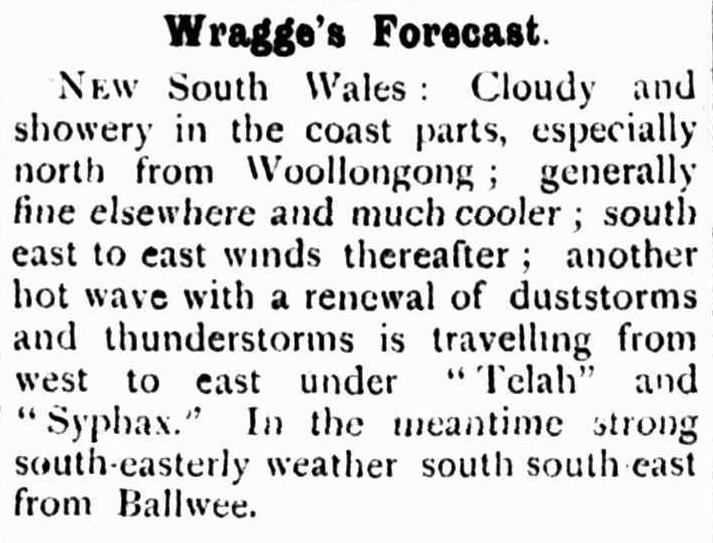

In [ ]:
displayImage(images[0], width=300)

By default, images are saved in the current directory. To change this, you can include the `output_dir` parameter to specify the directory where you want the images saved. If the directory doesn't exist, it will be created.

In [ ]:
images = download_images("107024751", output_dir="images")

Not all articles fit neatly in bounding boxes. If the article spans multiple, uneven columns, your image might contain content from neighbouring articles. By setting `masked` to `True` you can try to remove the irrelevant content.

Compare these two images of the same article. The first is unmasked, and includes a lot of extra content. The second is created by setting `masked=True` and only includes the desired article.

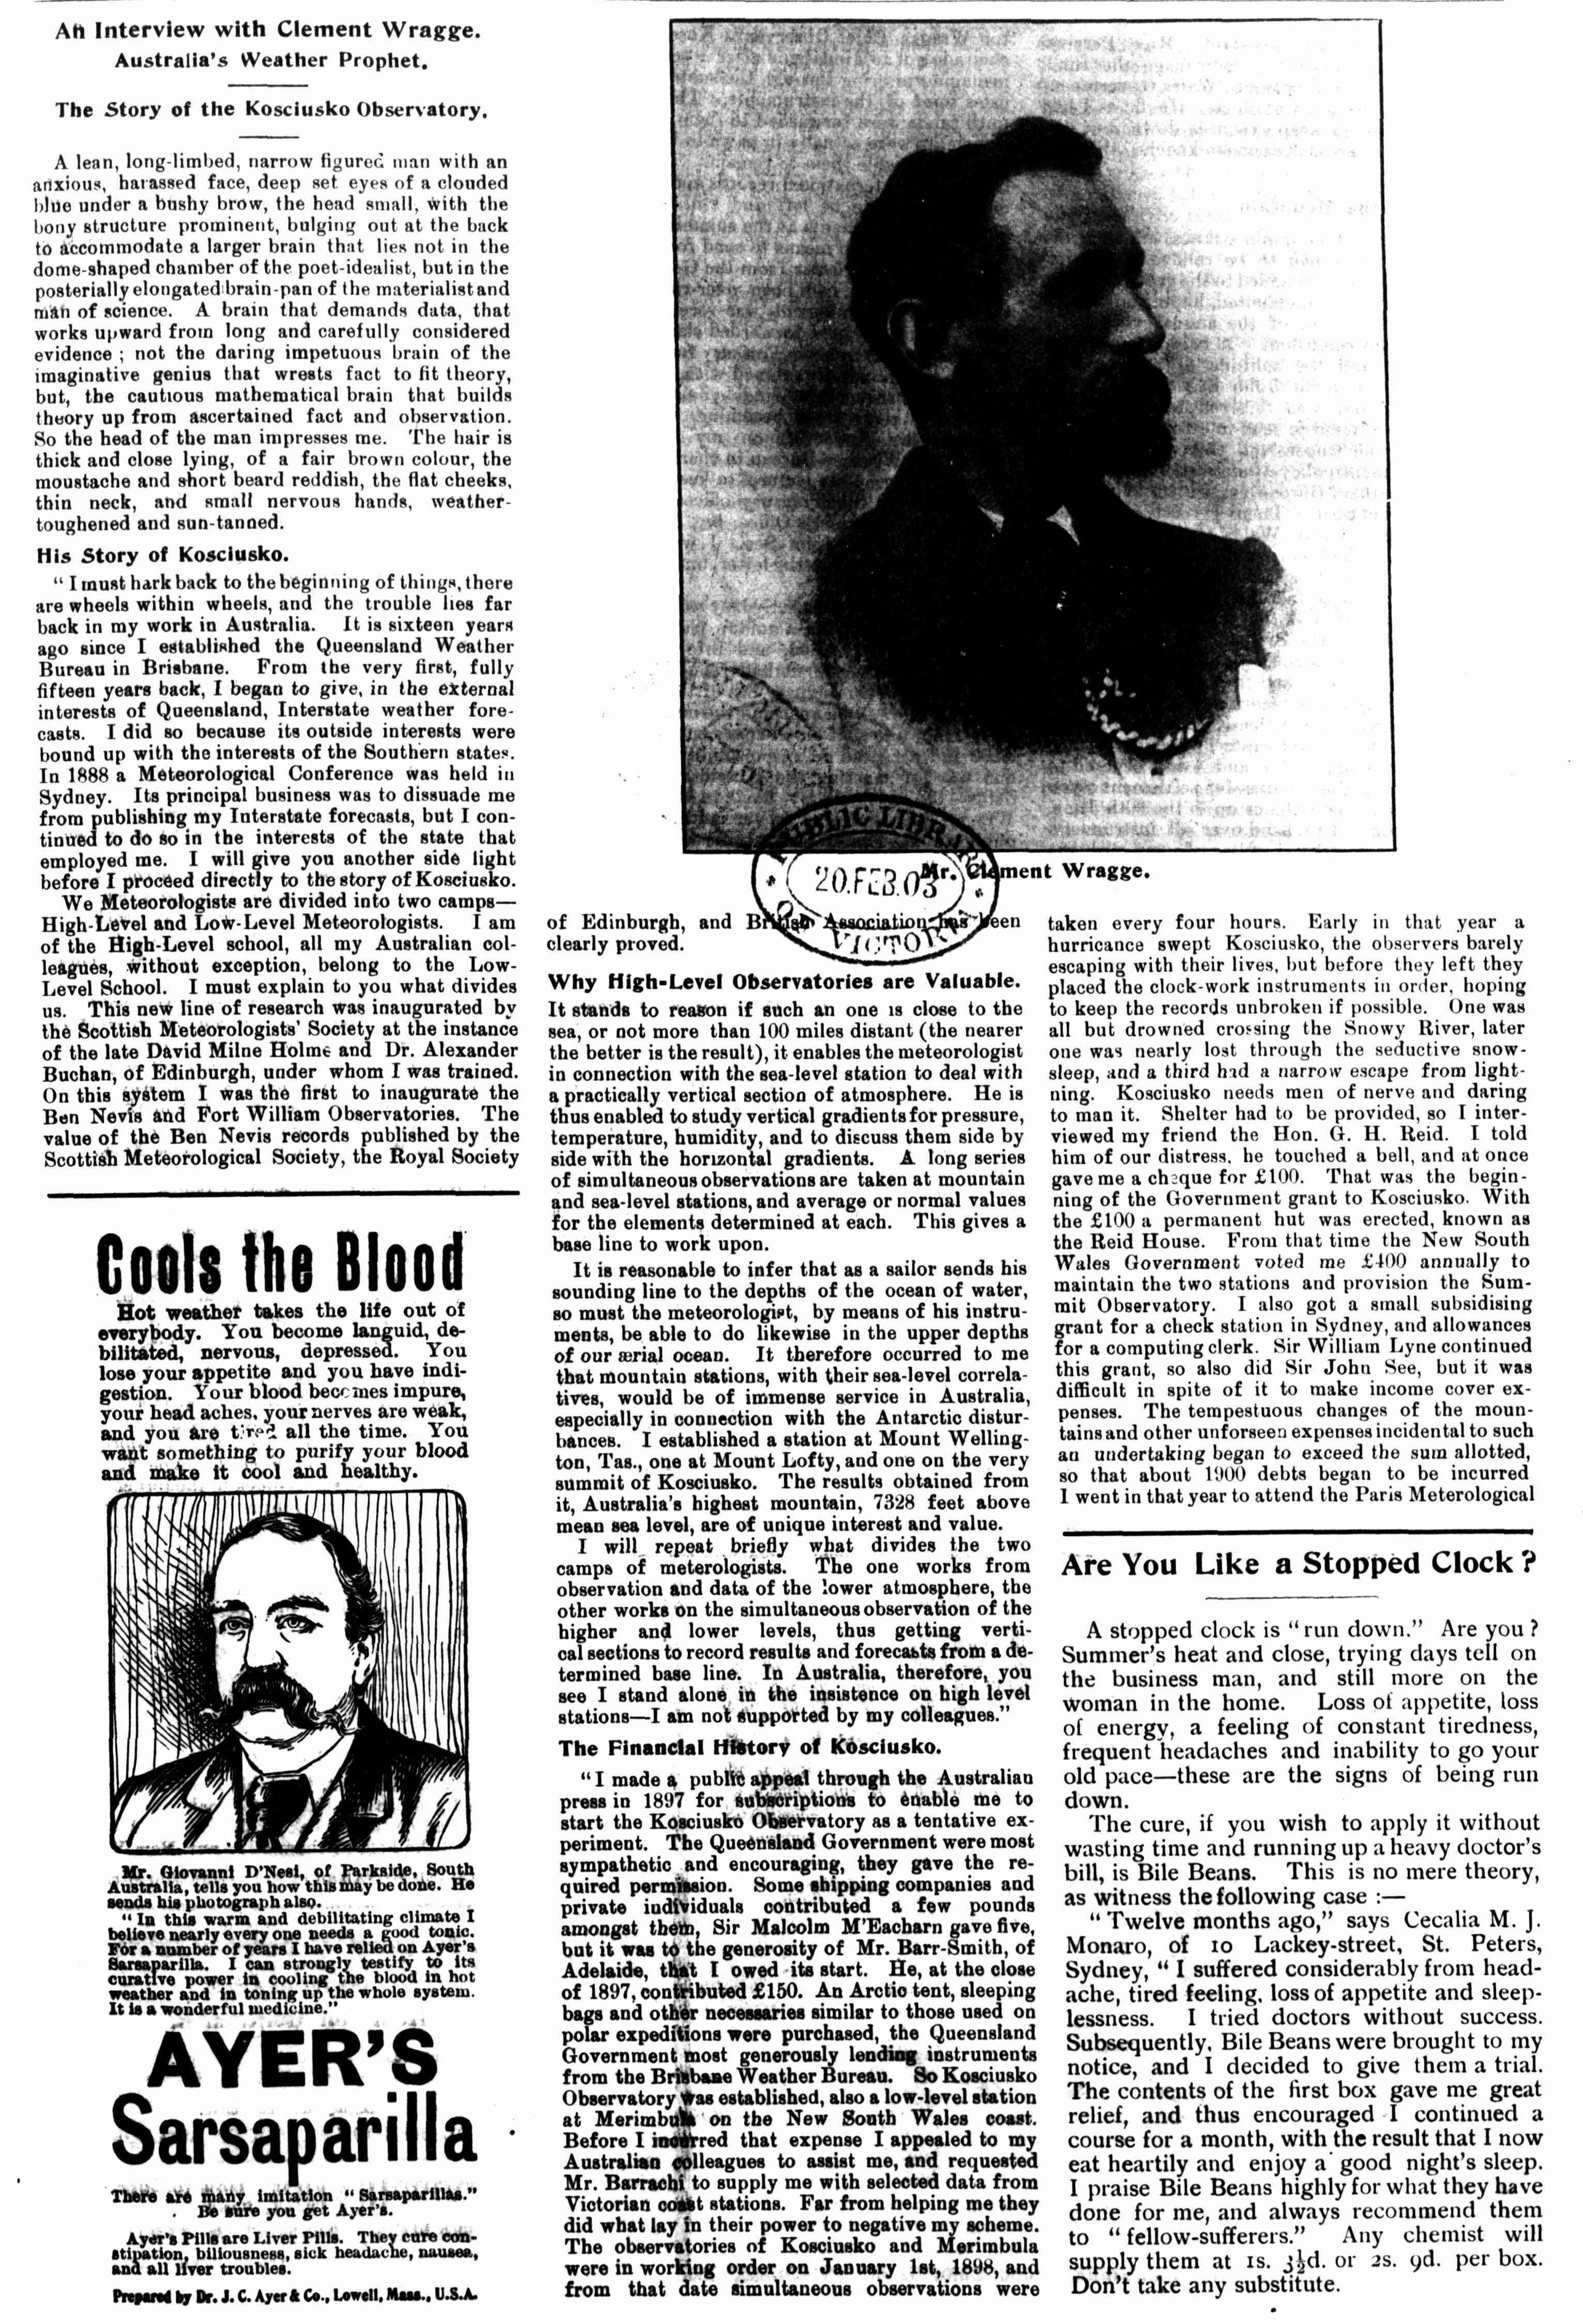

In [ ]:
images = download_images("255909273", output_dir="unmasked")
displayImage(Path("unmasked", images[0]), width=300)

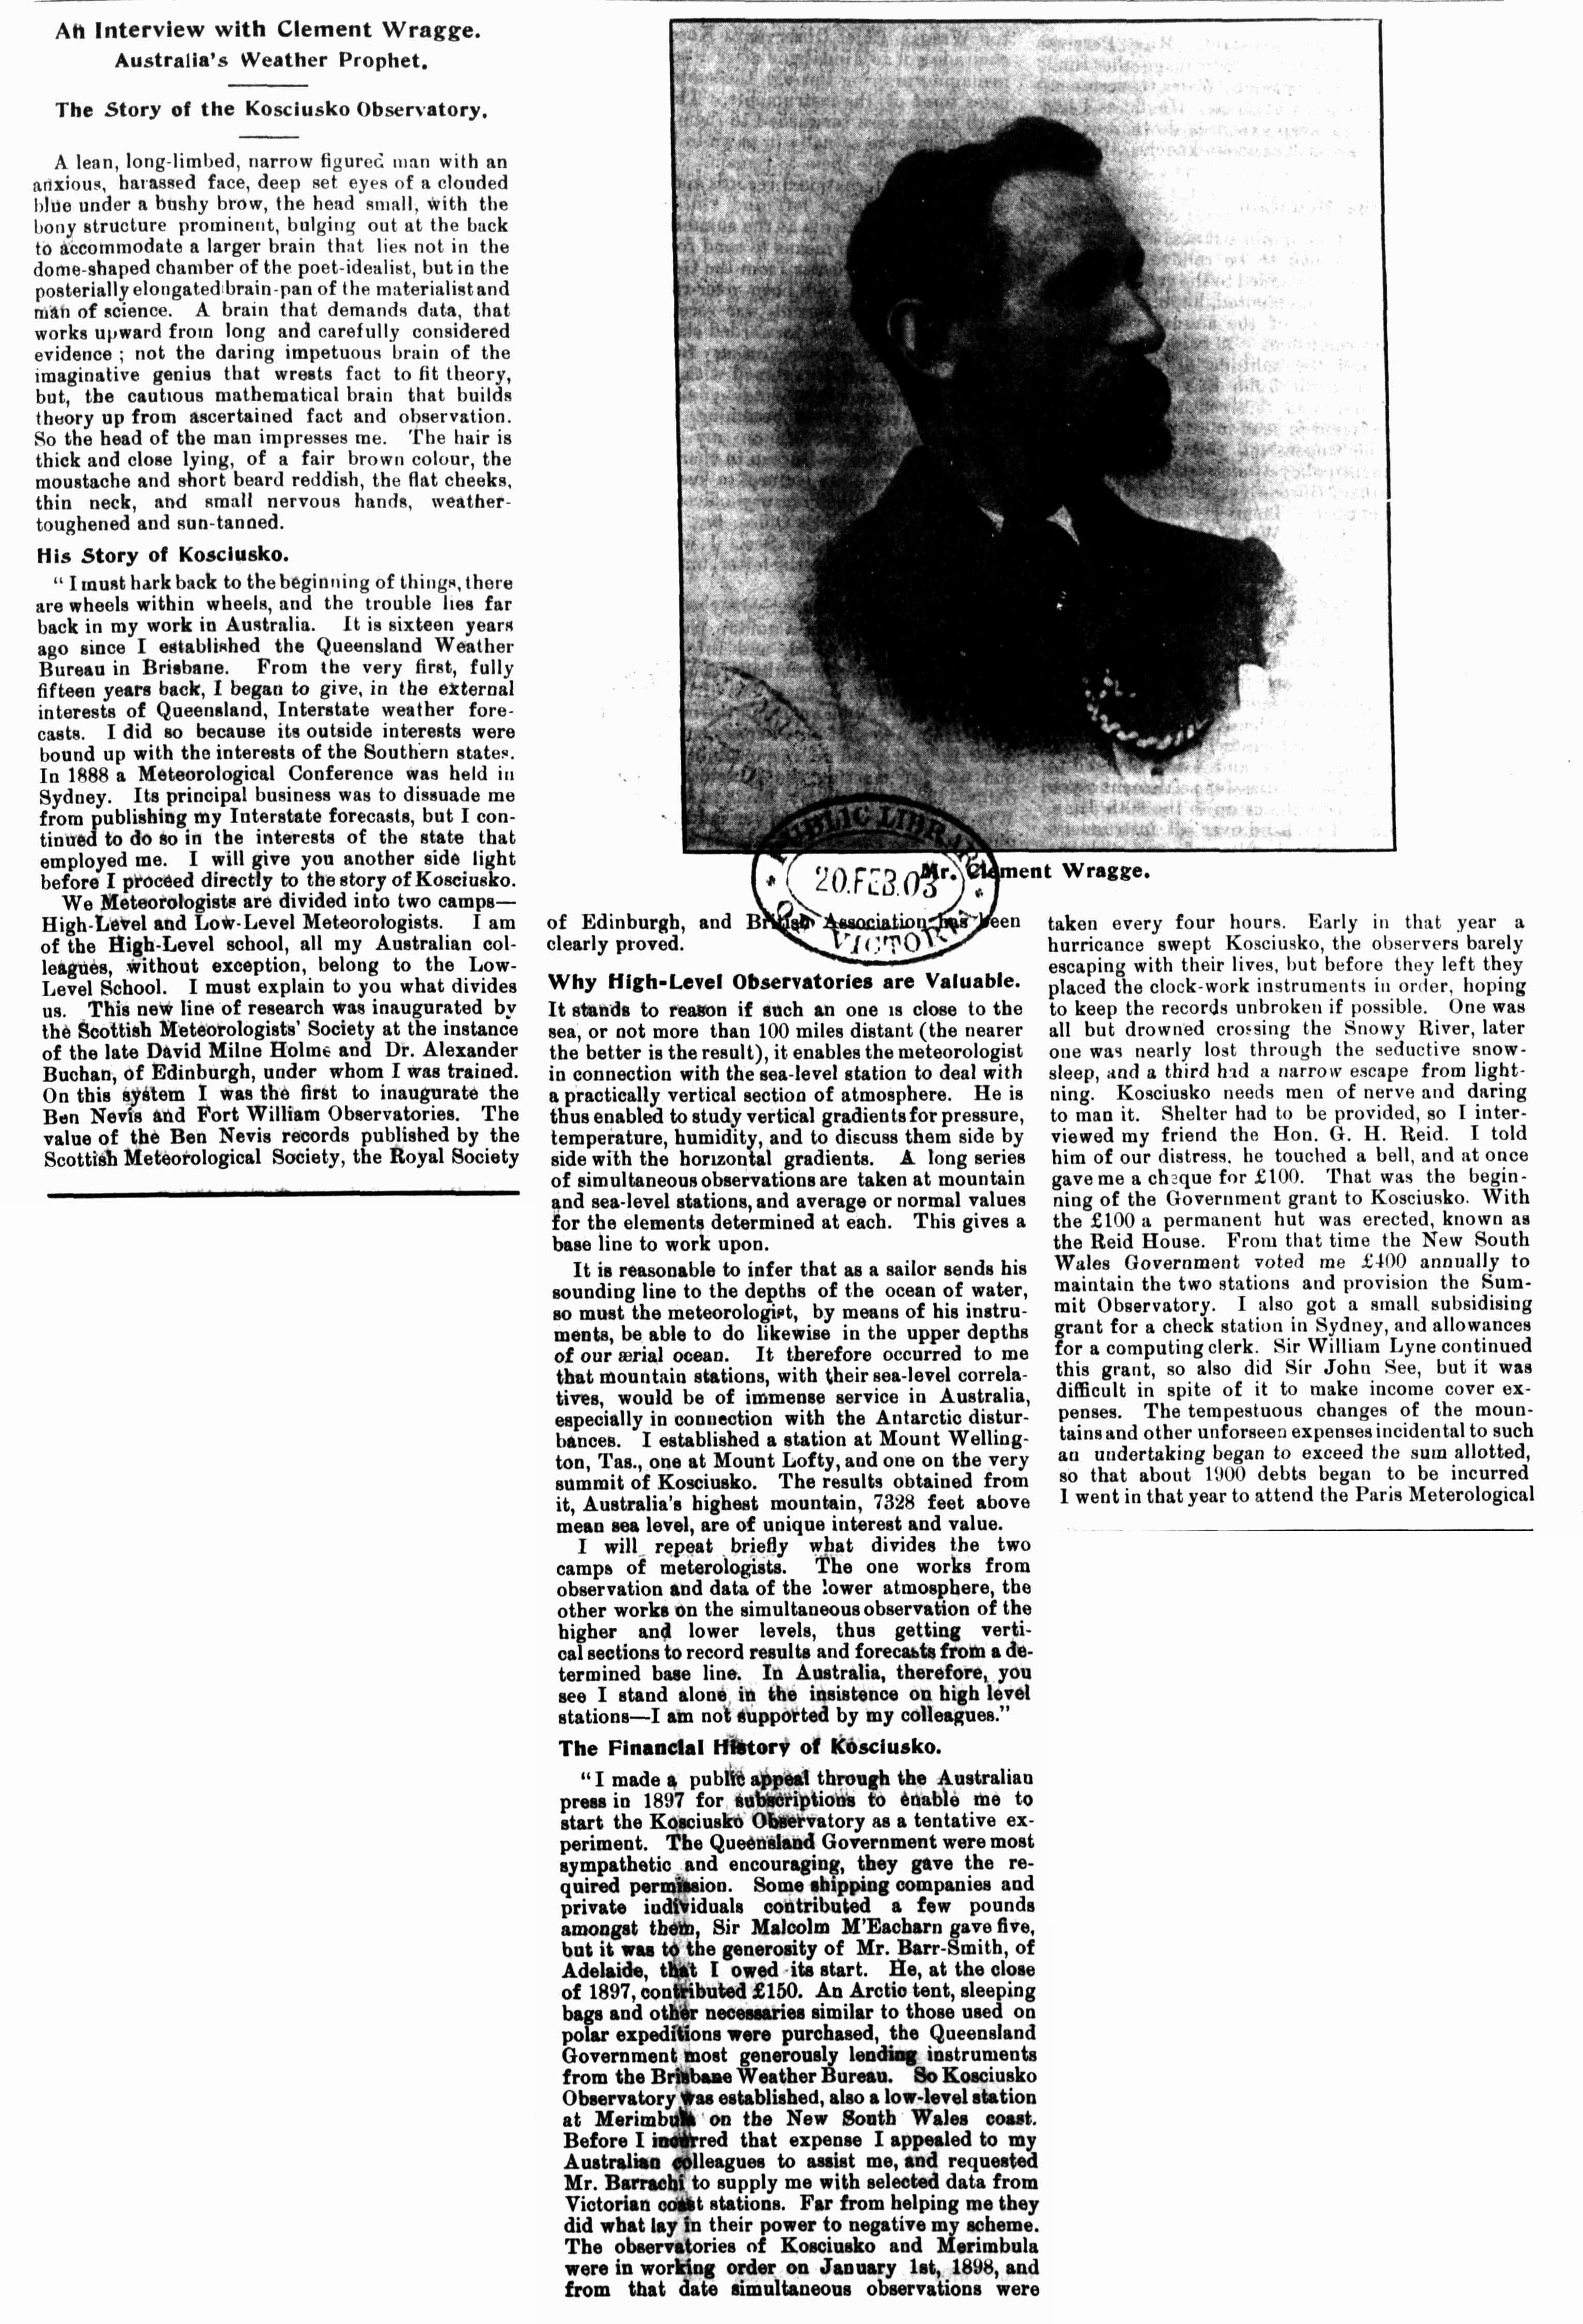

In [ ]:
images = download_images("255909273", output_dir="masked", masked=True)
displayImage(Path("masked", images[0]), width=300)

The accuracy of the mask depends on the way the boundaries of the article have been identified in Trove. Sometimes an article will be grouped with a neighbouring illustration, even though they're not connected.

## Tests

The `get_article_boxes` function resturns a list of bounding boxes defining the position of an article on a page.

In [ ]:
boxes = get_article_boxes("107024751")
boxes

[{'page_id': '11565831',
  'left': 1062,
  'top': 1406,
  'right': 1775,
  'bottom': 1949,
  'zones': [{'left': 1062, 'top': 1406, 'right': 1775, 'bottom': 1467},
   {'left': 1062, 'top': 1469, 'right': 1775, 'bottom': 1949}]}]

This article is printed on one page only, so `get_article_boxes` should return a list containing a single box.

In [ ]:
assert len(boxes) == 1

Each box includes a `page_id` value, providing the identifier of the page on which the article is printed.

In [ ]:
assert "page_id" in boxes[0]

The bounding box has `left`, `right`, `top`, and `bottom` values. We'd expect `left` to be less that `right`.

In [ ]:
assert boxes[0]["left"] < boxes[0]["right"]

Let's try an article that is split across multiple pages.

In [ ]:
boxes = get_article_boxes("162833980")

There should be two boxes.

In [ ]:
assert len(boxes) == 2

The `download_images` function downloads the images and returns a list of image names.

In [ ]:
images = download_images("107024751")
images

['nla.news-article107024751-11565831.jpg']

There should be a single image file name in the `images` list.

In [ ]:
assert len(images) == 1

The image file names should include the article id.

In [ ]:
assert "107024751" in images[0]

Let's check that the image has been downloaded and saved.

In [ ]:
assert Path(images[0]).exists()

# Delete the image
Path(images[0]).unlink()

Let's use the `output_dir` parameter to save the image to a specified directory.

In [ ]:
images = download_images("107024751", output_dir="images-test")

Let's make sure the image has been saved to the directory.

In [ ]:
assert Path("images-test", images[0]).exists()

Let's download an article split across multiple pages.

In [ ]:
images = download_images("162833980")

In [ ]:
assert len(images) > 1

And check that all the images have been downloaded.

In [ ]:
for img in images:
    assert Path(img).exists()

# Delete downloaded images
for img in images:
    Path(img).unlink()

In [ ]:
# Clean up after tests
shutil.rmtree(Path("images"))
shutil.rmtree(Path("images-test"))
shutil.rmtree(Path("masked"))
shutil.rmtree(Path("unmasked"))

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()